# Downscaling climate data using deep learning

The [Project CCHAIN dataset](https://thinkingmachines.github.io/project-cchain) contains daily climate variables usable in health and other applied research. However, the values are from coarse global gridded data and are not resolved for barangay level (village level in the Philippines). 

Computational methods called **climate downscaling** addresses this issue by using simulations or statistical processes to increase the resolution of coarse climate data. A technique called *dynamical climate downscaling* uses physics equations simulating large-scale atmospheric systems to approximate a desired finer resolution. However, this method takes large computational resources, both on hardware and runtime. Recent advances in the past decade has allowed machine learning models to help push downscaling forward by detecting and transferring patterns from available high resolution data (e.g., from weather stations, radar) to correct coarse resolution data. The end result is also higher resolution climate data but produced significantly faster and requires less resources. 

Open source machine learning models that downscale climate data have been developed by leading institutions in developed nations. One such model is [dl4ds](https://github.com/carlos-gg/dl4ds),  a python module that implements range of architechtures for downscaling gridded  data with deep neural networks  [(Gonzales, 2023)](https://www.cambridge.org/core/journals/environmental-data-science/article/dl4dsdeep-learning-for-empirical-downscaling/5D0623A860C6082FD650D704A50BEF3D).

With support from the Lacuna Fund, we are able to create this code that allows us to improve the resolution of temperature and rainfall data to bring it down to the local level. 


## Import libraries

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import xskillscore as xs

import dl4ds as dds
import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import sys
import ast

import os, sys
from pathlib import Path
sys.path.append("../../") 
from src.assess_model import *
from src.downscaling_utils import *

## Obtaining the data
To run the notebook, please download the files inside [this folder](https://drive.google.com/drive/u/0/folders/1rbPxDZ1OmIGRNADSG1T_8eqVlx7KXqmp) and put in a folder named `data/` in your repo directory. 
The following are the dataset contained in the folders, cropped to city latlon bounds 
1. `01-raw` - contains the domain definition as latlon bounding box, shapefiles for plotting maps
2. `02-processed\model-input` - contains the netcdf files with the model input variables
    - `elevation_hr_<city_name>.nc` and `elevation_lr_<city_name>.nc` - contains SRTM data cropped to city latlon bounds in 0.02 degree
    - `elevation_mask_hr_<city_name>.nc` and `elevation_mask_lr_<city_name>.nc` - contains the mask used where 1=land, 0=ocean based on elevation
    - `predictors_lr_<city_name>.nc`- contains the realigned ERA5 reanalysis predictor variables realigned (list vars here)
    - `ref_hr_<city_name>.nc`- contains the realigned CHIRPS/CHIRTS + station data variables in 0.02 degree
    - `ndvi_hr_<city_name>.nc`- contains the realigned NDVI predictor variables in 0.02 degree
    

## Define paths and variables
Change `CITY_NAME`, `VARIABLE` and the path variables (if needed) to locate the necessary files

In [5]:
RAW_INPUT_PATH = Path("../../data/01-raw/")
INPUT_PATH = Path("../../data/02-processed/")
MODEL_PATH = Path("../../model/")
RESULTS_PATH = Path("../../data/03-results/")
CITY_NAME = 'Zamboanga'
VARIABLE = 'tmax'
YEARS = np.arange(2003,2023,1)

if VARIABLE == 'precip': 
    train_years = [2007,2009,2016,2018]
    test_years = [2017]
    val_years = [2008]
elif VARIABLE in ['tmin', 'tmax']: 
    train_years = [2007,2009]
    test_years = [2016]
    val_years = [2008]

rollout_years = [year for year in YEARS]

## Read bounds
Use `full_bounds` to define extend of model output, and `focused_bounds` for model evaluation, zooming in on city of interest.

In [10]:
bounds_df = pd.read_csv(RAW_INPUT_PATH / 'domains' / 'downscaling_domains_fixed.csv')
bounds_df['full_bounds'] = bounds_df['full_bounds'].apply(ast.literal_eval)
bounds_df['focused_bounds'] = bounds_df['focused_bounds'].apply(ast.literal_eval)
bounds_df.head()

,city,full_bounds,focused_bounds
0,Dagupan,"[120.00931049408791, 120.4821769636825, 15.907...","[120.210342, 120.450668, 15.928978, 16.138177]"
1,Palayan,"[120.8625098711998, 121.33347866342953, 15.294...","[121.042557, 121.131134, 15.495371, 15.584679]"
2,MetroManila,"[120.8470354518582, 121.22452516891933, 14.273...","[120.8670354518582, 121.20452516891933, 14.293..."
3,Legazpi,"[123.63316781038878, 123.90749473184147, 12.97...","[123.68657, 123.767166, 13.113921, 13.205771]"
4,Iloilo,"[122.41374050886832, 122.69006942567574, 10.61...","[122.477646, 122.602422, 10.676429, 10.80698]"


In [11]:
city_bounds_df = bounds_df[bounds_df['city']==CITY_NAME].copy()
city_bounds_df

,city,full_bounds,focused_bounds
7,Zamboanga,"[121.85371390413884, 122.48448071157127, 6.812...","[122.013817, 122.199554, 6.852464, 7.015031]"


In [12]:
city_bounds = city_bounds_df['full_bounds'].values[0]
city_focus_bounds = city_bounds_df['focused_bounds'].values[0]
city_focus_bounds

[122.013817, 122.199554, 6.852464, 7.015031]

## Data preprocessing
Section data into training, testing and evaluation years

In [13]:
cd_lr = xr.load_dataset(INPUT_PATH / "model_input" / f"predictors_lr_{CITY_NAME.lower()}.nc")
cd_hr = xr.load_dataset(INPUT_PATH / "model_input" / f"ref_hr_{CITY_NAME.lower()}.nc")

In [14]:
def section_cd_data(ds,train_years,test_years,val_years,rollout_years=None):
    ds_train = ds.sel(time= ds.time.dt.year.isin(train_years))
    ds_test = ds.sel(time= ds.time.dt.year.isin(test_years))
    ds_val = ds.sel(time= ds.time.dt.year.isin(val_years))
    if rollout_years:
        ds_rollout = ds.sel(time= ds.time.dt.year.isin(rollout_years))
        return [ds_train,ds_test,ds_val,ds_rollout]
    return [ds_train,ds_test,ds_val]

In [15]:
cd_lr_train,cd_lr_test,cd_lr_val,cd_lr_rollout = section_cd_data(cd_lr, train_years,test_years,val_years,rollout_years)
cd_train,cd_test,cd_val = section_cd_data(cd_hr, train_years,test_years,val_years)

In [16]:
# rollout container
rollout_lat = cd_train['lat']
rollout_lon = cd_train['lon']
rollout_time = cd_lr_rollout['time']

# Create a new dataset with the lat, lon, and time dimensions and initialize all values to 0
cd_container_rollout = xr.Dataset({VARIABLE: (['time', 'lat', 'lon'], np.zeros((len(rollout_time), len(rollout_lat), len(rollout_lon))))},
                    coords={'time': rollout_time,'lat': rollout_lat,'lon': rollout_lon})
cd_container_rollout

<xarray.Dataset>
Dimensions:  (time: 7305, lat: 40, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2022-12-31
  * lat      (lat) float64 6.813 6.833 6.853 6.873 ... 7.533 7.553 7.573 7.593
  * lon      (lon) float64 121.8 121.8 121.8 121.9 ... 122.5 122.5 122.6 122.6
Data variables:
    tmax     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [17]:
# additional
ndvi_hr = xr.load_dataset(INPUT_PATH / "model_input" / f"ndvi_hr_{CITY_NAME.lower()}.nc")
ndvi_train,ndvi_test,ndvi_val, ndvi_rollout = section_cd_data(ndvi_hr, train_years,test_years,val_years, rollout_years)
ndvi_train

<xarray.Dataset>
Dimensions:  (time: 730, lat: 40, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2009-12-31
  * lat      (lat) float64 6.813 6.833 6.853 6.873 ... 7.533 7.553 7.573 7.593
  * lon      (lon) float64 121.8 121.8 121.8 121.9 ... 122.5 122.5 122.6 122.6
Data variables:
    ndvi     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/40)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDPLATFORMSHORTNAME.2:      Aqua
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    ASSOCIATEDSENSORSHORTNAME.2:        MODIS
    ...                                 ...
    SHORTNAME:                          MCD19A3CMG
    SOUTHBOUNDINGCOORDINATE:            -90.0
    SPSOPARAMETERS:                     None
    VERSIONID:                          61
    WESTBOUNDINGCOORDINATE:             -180.0
    regrid_method:                      bilinear

In [18]:
#mask 
mask_hr =  xr.load_dataset(INPUT_PATH / 'model_input' / f"elevation_mask_hr_{CITY_NAME.lower()}.nc")
mask_data = mask_hr['elevation_mask'].values

## Extract variables
Get variable arrays that will be used as input to the model

In [19]:
### REQUIRED
# hi res tmax - CHIRTS
tmax_hr_train,tmax_hr_test,tmax_hr_val, tmax_hr_dummy_rollout = [x[VARIABLE] for x in [cd_train,cd_test,cd_val, cd_container_rollout]]
# low res tmax - ERA5
tmax_lr_train, tmax_lr_test, tmax_lr_val, tmax_lr_rollout = [x['t2m_max'] for x in [cd_lr_train,cd_lr_test,cd_lr_val, cd_lr_rollout]]

ndvi_hr_train, ndvi_hr_test, ndvi_hr_val, ndvi_hr_rollout = [x['ndvi'] for x in [ndvi_train,ndvi_test,ndvi_val, ndvi_rollout]]


In [20]:
predictor_variables = [name for name in cd_lr_train.data_vars if name not in ['t2m_min','t2m_mean','t2m_max', 'ndvi']]
predictor_variables_lookup = dict(enumerate(predictor_variables))
predictor_variables_idx_lookup = dict(zip(predictor_variables_lookup.values(),predictor_variables_lookup.keys()))
#predictor_variables = [name for name in cd_lr_train.data_vars if 'min' not in name]
print(predictor_variables)

['u10_mean', 'v10_mean', 'd2m_mean', 'sp_mean', 'tcc_mean', 'u10_min', 'v10_min', 'd2m_min', 'sp_min', 'tcc_min', 'u10_max', 'v10_max', 'd2m_max', 'sp_max', 'tcc_max', 'tp']


In [21]:
#train,test,val
train_lr_vars = [cd_lr_train[varname] for varname in predictor_variables]
test_lr_vars = [cd_lr_test[varname] for varname in predictor_variables]
val_lr_vars = [cd_lr_val[varname] for varname in predictor_variables]
rollout_lr_vars = [cd_lr_rollout[varname] for varname in predictor_variables]

## Scale the data
Apply a standard scaler and expand dimensions to match channel requirements for the model.

In [23]:
def scale_data(data_list):
    scaler_train = dds.StandardScaler(axis=None)
    if len(data_list) == 4: 
        data_train, data_test, data_val, data_rollout = data_list
    else:
        data_train, data_test, data_val= data_list
        
    scaler_train.fit(data_train) 

    s_train = scaler_train.transform(data_train).expand_dims(dim='channel', axis=-1)
    s_test = scaler_train.transform(data_test).expand_dims(dim='channel', axis=-1)
    s_val = scaler_train.transform(data_val).expand_dims(dim='channel', axis=-1)
    if len(data_list) == 4: 
        s_rollout = scaler_train.transform(data_rollout).expand_dims(dim='channel', axis=-1)
        return scaler_train, [s_train, s_test, s_val, s_rollout]
    return scaler_train, [s_train, s_test, s_val]

In [24]:
# reference data
# define dummy rollout 
tmax_hr_scaler, [y_train, y_test, y_val, y_dummy_rollout] = scale_data([tmax_hr_train,tmax_hr_test,tmax_hr_val, tmax_hr_dummy_rollout])
# low-res target data
tmax_lr_scaler, [x_train, x_test, x_val, x_rollout] = scale_data([tmax_lr_train,tmax_lr_test,tmax_lr_val, tmax_lr_rollout])

# low-res predictors
scalers = []
predictors_train = []
predictors_test = []
predictors_val = []
predictors_rollout = []
for var_train, var_test, var_val, var_rollout in zip(train_lr_vars,test_lr_vars, val_lr_vars, rollout_lr_vars):
    v_scaler, [v_train, v_test, v_val, v_rollout] = scale_data([var_train, var_test, var_val, var_rollout])
    scalers.append(v_scaler)
    predictors_train.append(v_train)
    predictors_test.append(v_test)
    predictors_val.append(v_val)
    predictors_rollout.append(v_rollout)

# add NDVI (hi-res) to predictors
v_scaler, [v_train, v_test, v_val, v_rollout] = scale_data([ndvi_hr_train, ndvi_hr_test, ndvi_hr_val, ndvi_hr_rollout])
scalers.append(v_scaler)
predictors_train.append(v_train)
predictors_test.append(v_test)
predictors_val.append(v_val)


In [25]:
# Check array shapes
print(y_train.shape, y_test.shape, y_val.shape)
print(x_train.shape, x_test.shape, x_val.shape)
print([np.shape(p) for i,p in enumerate(predictors_train)])

(730, 40, 40, 1) (366, 40, 40, 1) (366, 40, 40, 1)
(730, 8, 8, 1) (366, 8, 8, 1) (366, 8, 8, 1)
[(730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 8, 8, 1), (730, 40, 40, 1)]


## Model Training and Testing

Run the training loop for 100 epochs. In this case, we train a network with a ResNet backbone, 8 residual blocks, in post-upsampling via subpixel convolution (implicit training pairs), and a localized convolutional block. 

In [26]:
ARCH_PARAMS = dict(n_filters=8,
                   n_blocks=8,
                   normalization=None,
                   dropout_rate=0.0,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=True)

In [27]:
def run_downscaling(x_lr, y_hr, predictors_lr, selected_predictors_list):
    y_train, y_test, y_val, y_dummy_rollout = y_hr
    x_train, x_test, x_val, x_rollout = x_lr
    predictors_train, predictors_test, predictors_val, predictors_rollout = predictors_lr
    print("====================================================")
    print(f'Training model with predictors {selected_predictors_list}...')
    selected_predictors_idx = [predictor_variables_idx_lookup[p] for p in selected_predictors_list]
    predictors_train = [predictors_train[idx] for idx in selected_predictors_idx]
    predictors_test = [predictors_test[idx] for idx in selected_predictors_idx]
    predictors_val = [predictors_val[idx] for idx in selected_predictors_idx]
    trainer = dds.SupervisedTrainer(
        backbone='resnet',
        upsampling='spc', 
        data_train=y_train, 
        data_val=y_val,
        data_test=y_test,
        data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
        data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
        data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
        scale=5, # scale must correspond to the desired resolution increase factor from the input to the target scale
        time_window=None, 
        static_vars=None,
        predictors_train=predictors_train,
        predictors_val=predictors_val,
        predictors_test=predictors_test,
        interpolation='inter_area',
        patch_size=None, 
        batch_size=100, 
        loss='mse',
        epochs=100, 
        steps_per_epoch=None, 
        validation_steps=None, 
        test_steps=None, 
        learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
        early_stopping=False, patience=6, min_delta=0, 
        save=False, # set to False if no need to save the model
        save_path= str(MODEL_PATH/f'downscaler_{VARIABLE}_{CITY_NAME.lower()}'),
        show_plot=True, verbose=True, 
        device='CPU', 
        **ARCH_PARAMS)

    trainer.run()
    print('DONE!')
    #predict
    print(f'Computing predictions...')
    # val, test, rollout
    pred_output = []

    # Generate predictions for test, val, rollout
    for target_array, predictor in zip([x_test,x_val,x_rollout],[predictors_test, predictors_val, predictors_rollout]):
        print(target_array.shape)
        pred = dds.Predictor(
            trainer, 
            target_array, 
            scale=5, 
            array_in_hr=False,
            static_vars=None, 
            predictors=predictor, 
            time_window=None,
            interpolation='inter_area', 
            batch_size=50,
            scaler=tmax_hr_scaler,
            save_path=None,
            save_fname=None,
            return_lr=True,
            device='CPU')

        unscaled_y_pred, coarsened_array = pred.run()
        pred_output.append(unscaled_y_pred)
    print('DONE!')
    return pred_output

In [28]:
x_lr =  [x_train, x_test, x_val, x_rollout]
y_hr = [y_train, y_test, y_val, y_dummy_rollout]
predictors_lr = [predictors_train, predictors_test, predictors_val, predictors_rollout]
selected_predictors_list = [p for p in predictor_variables if ('elevation' not in p)] #['ndvi','elevation','u10_mean', 'v10_mean','d2m_mean', 'sp_mean']
pred_output = run_downscaling(x_lr, y_hr, predictors_lr, selected_predictors_list)

Training model with predictors ['u10_mean', 'v10_mean', 'd2m_mean', 'sp_mean', 'tcc_mean', 'u10_min', 'v10_min', 'd2m_min', 'sp_min', 'tcc_min', 'u10_max', 'v10_max', 'd2m_max', 'sp_max', 'tcc_max', 'tp']...
List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 100
--------------------------------------------------------------------------------
Starting time: 2024-09-26 10:33:59
--------------------------------------------------------------------------------


2024-09-26 10:33:59.667839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/cv2/../../lib64:
2024-09-26 10:33:59.668332: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-26 10:33:59.668407: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (FTE-JCP-LW01): /proc/driver/nvidia/version does not exist
2024-09-26 10:33:59.708675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

Model: "resnet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 8, 8, 17)]               0                 []                                                
                                                                                                                                                      
 conv2d (Conv2D)                                 (None, 8, 8, 8)                  1232              ['input_1[0][0]']                                 
                                                                                                                                                      
 ResidualBlock1 (ResidualBlock)                  (None, 8, 8, 8)          

### Postprocess output
Process the model’s output for evaluation.

In [31]:
def postprocess_pred(raw_pred, da_pred_template, mask_data):
    # clean
    unscaled_y_pred_masked = np.where(mask_data == 0, np.nan, raw_pred)
    # rain < 0, rain <1 = consider as rain=0
    unscaled_y_pred_masked = np.where(unscaled_y_pred_masked<1, 0, unscaled_y_pred_masked)
    # add coords using test
    da_pred =  da_pred_template.copy()
    da_pred.values = unscaled_y_pred_masked
    cd_pred  = da_pred.to_dataset()
    #apply median filter
    cd_pred = apply_filter(cd_pred, VARIABLE, window=3)
    #da_hr_pred = cd_pred[variable]
    #crop to true bounds
    lon0,lon1,lat0,lat1 = city_bounds
    cd_pred = cd_pred.sel(lon=slice(lon0,lon1), lat=slice(lat0,lat1))
    return cd_pred

In [32]:
# Apply postprocess function
# test 
cd_pred_test = postprocess_pred(pred_output[0], tmax_hr_test, mask_data)
tmax_pred_test = cd_pred_test[VARIABLE]
# val
cd_pred_val = postprocess_pred(pred_output[1], tmax_hr_val, mask_data)
tmax_pred_val = cd_pred_val[VARIABLE]
# rollout
cd_pred_rollout = postprocess_pred(pred_output[2], tmax_hr_dummy_rollout, mask_data)
tmax_pred_rollout = cd_pred_rollout[VARIABLE]

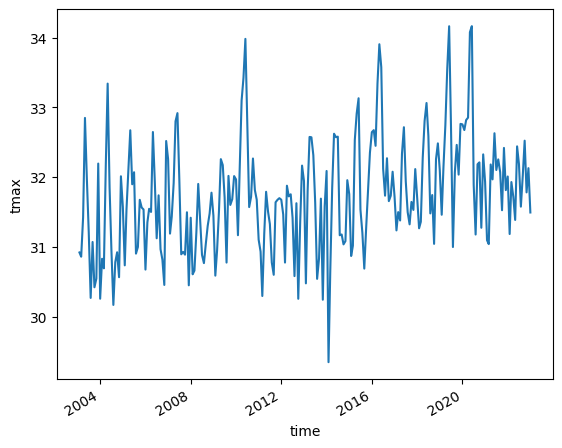

In [33]:
# Plot time series
test_mon_plot = cd_pred_rollout[VARIABLE].resample(time='1M').mean().mean(dim=['lat', 'lon'])
#test_mon_plot.sel(time=test_mon_plot.time.dt.year.isin([2003])).plot()
test_mon_plot.plot()

In [35]:
# Save model output as netCDF
cd_pred_rollout.to_netcdf(RESULTS_PATH/ VARIABLE /f'downscaled_{VARIABLE}_{CITY_NAME.lower()}.nc')

### Visualize results
Sense check results and view error metrics

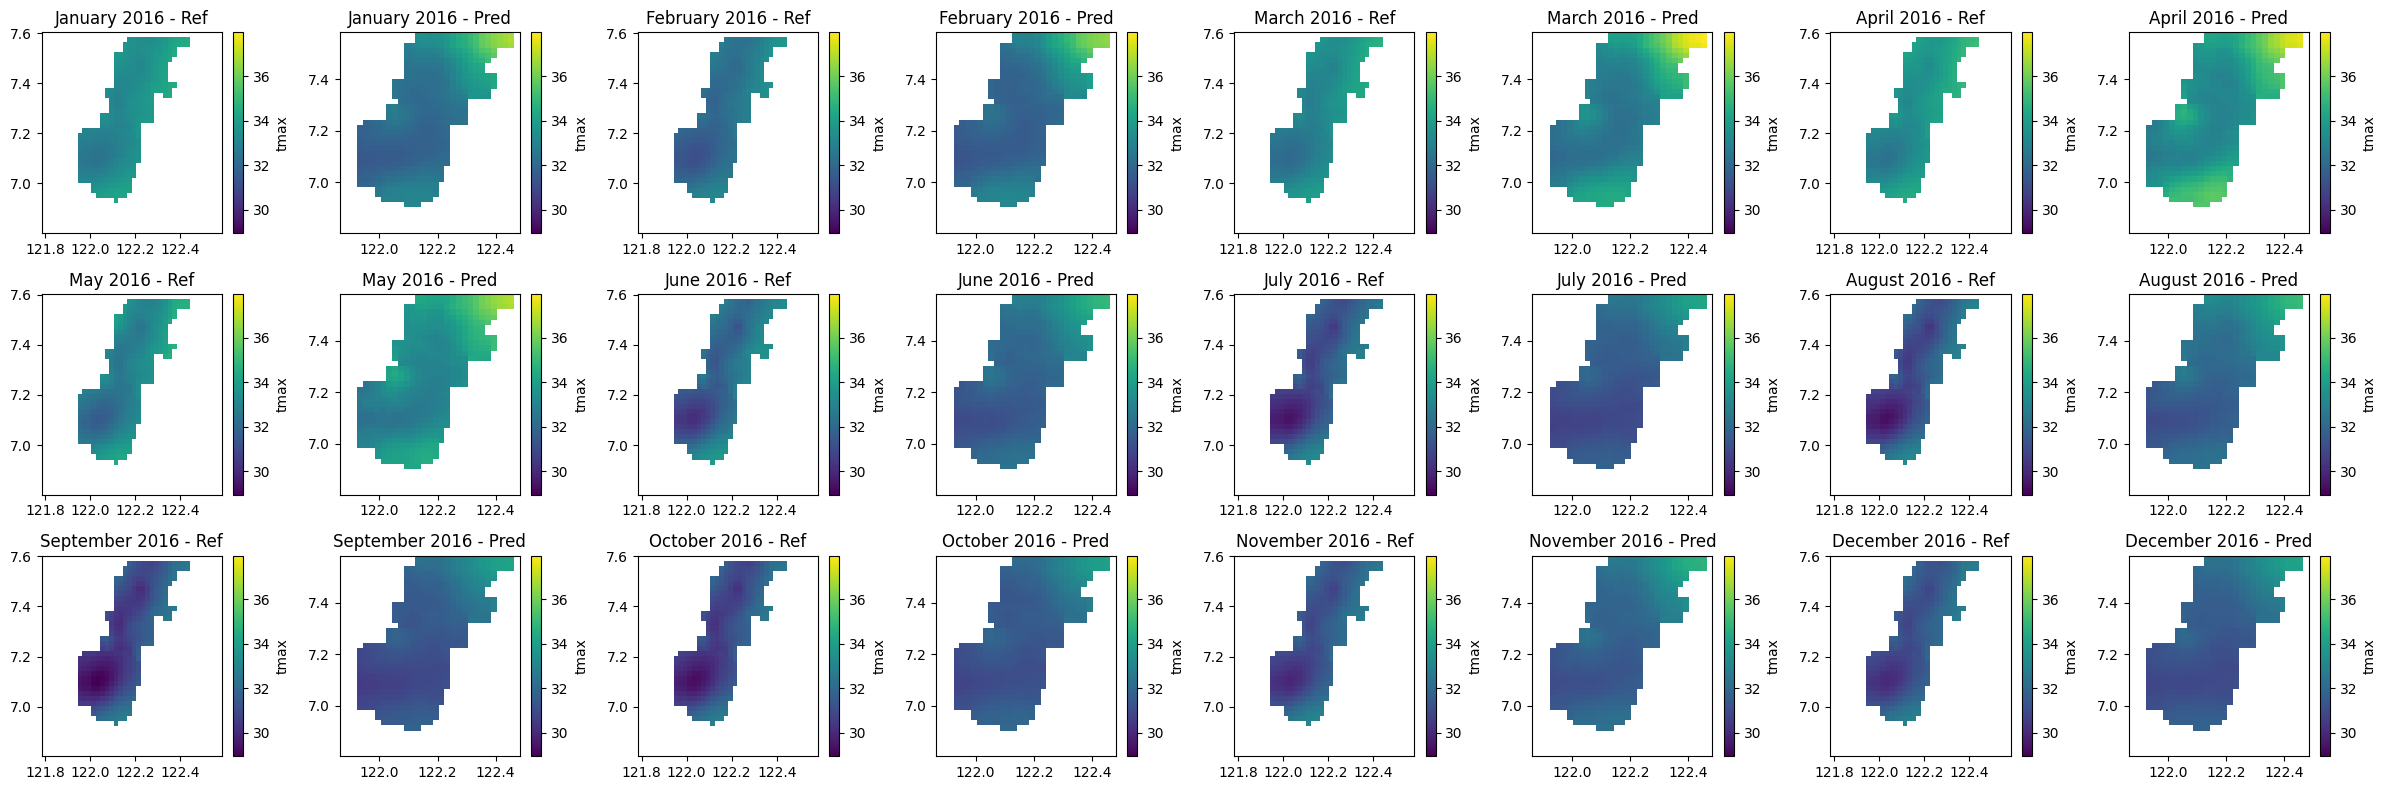

In [36]:
# Compare monthly means - spatial patterns
compare_monthly_means_map(tmax_hr_test, tmax_pred_test)

/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


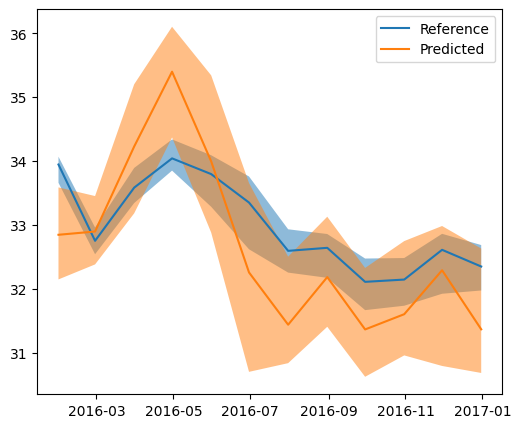

In [37]:
# Compare monthly means - range
compare_monthly_iqr_line(tmax_hr_test, tmax_pred_test, city_focus_bounds)

Text(0, 0.5, 'MAE - whole domain')

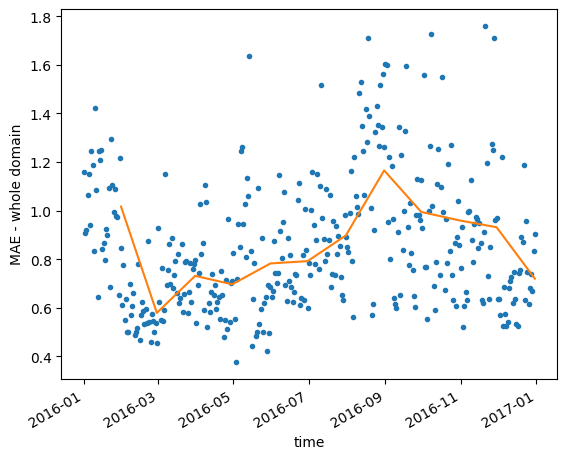

In [38]:
# Check MAE - daily and monthly mean for whole domain
lon0,lon1,lat0,lat1 = city_bounds
mae = xs.mae(tmax_hr_test.sel(lon=slice(lon0,lon1), lat=slice(lat0,lat1)),
            tmax_pred_test, dim=['lat', 'lon'], skipna=True).to_dataset()
#rmse = xs.rmse(precip_hr_test, precip_hr_pred, dim=['lat', 'lon'], skipna=True)
mae[VARIABLE].plot(lw=0,marker='.')
mae[VARIABLE].resample(time='1M').mean().plot()
plt.ylabel("MAE - whole domain")

Text(0, 0.5, 'MAE - focus area')

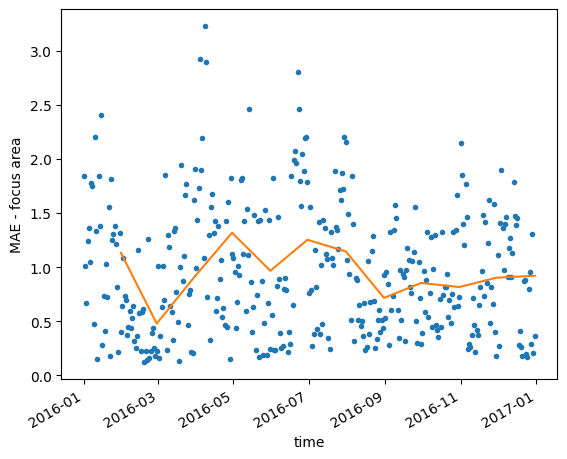

In [39]:
# Check MAE - daily and monthly mean for focus area
lon0,lon1,lat0,lat1 = city_focus_bounds
mae = xs.mae(tmax_hr_test.sel(lon=slice(lon0,lon1), lat=slice(lat0,lat1)),\
              tmax_pred_test.sel(lon=slice(lon0,lon1), lat=slice(lat0,lat1)),\
              dim=['lat', 'lon'], skipna=True).to_dataset()
#rmse = xs.rmse(precip_hr_test, precip_hr_pred, dim=['lat', 'lon'], skipna=True)
mae[VARIABLE].plot(lw=0,marker='.')
mae[VARIABLE].resample(time='1M').mean().plot()
plt.ylabel("MAE - focus area")

## Optional: View reference, low-res, and downscaled output side-by-side
Check if model has improved a certain timestep of interest

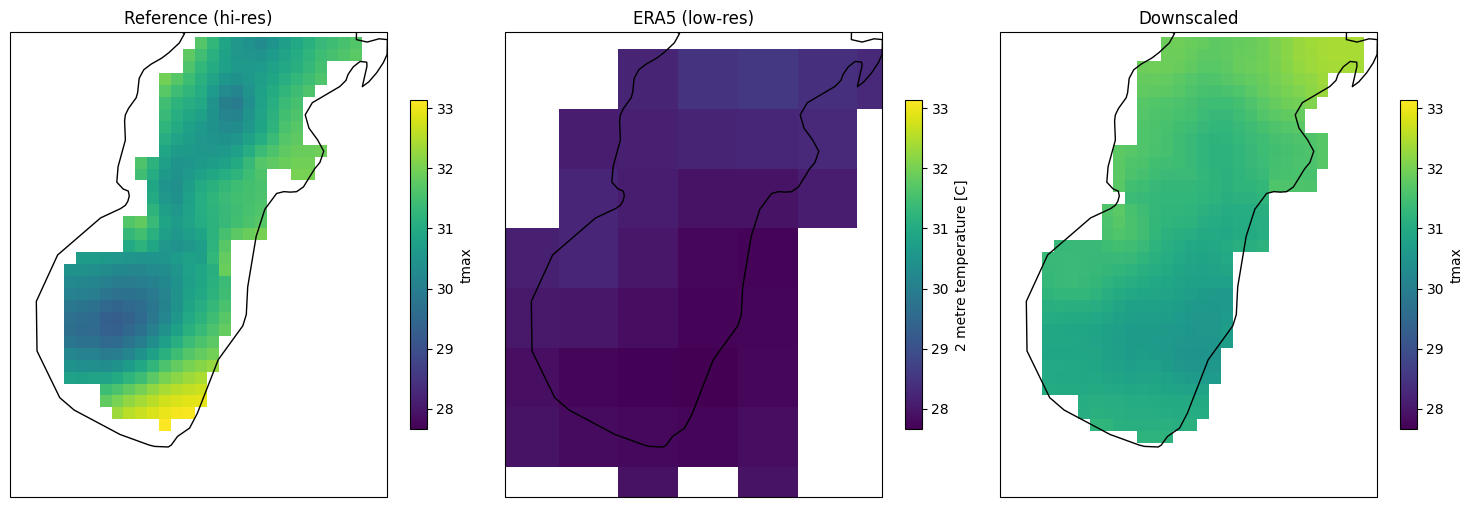

In [40]:
idx = 190
data1 = tmax_hr_test.isel(time=idx)
data2 = tmax_lr_test.isel(time=idx)
data3 = tmax_pred_test.isel(time=idx)

fig, axes = plt.subplots(1,3, figsize=(15,5), subplot_kw={'projection': ccrs.PlateCarree()})
# Ensure the same scale across all plots
vmin = min(data1.min().item(), data2.min().item(), data3.min().item())
vmax = max(data1.max().item(), data2.max().item(), data3.max().item())

data1.plot(ax=axes[0],vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.7})
axes[0].set_title('Reference (hi-res)')
axes[0].coastlines()

data2.plot(ax=axes[1],vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.7})
axes[1].set_title('ERA5 (low-res)')
axes[1].coastlines()

data3.plot(ax=axes[2],vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.7})
axes[2].set_title('Downscaled')
axes[2].coastlines()

city_extent = city_bounds
for ax in axes:
    ax.set_extent(city_extent, crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()